In [3]:
import pandas as pd

from preprocessors.preprocessor import Preprocessor

from preprocessors.scalers.min_max_scaler import MinMaxScalerData
from preprocessors.scalers.log_increases_scaler import LogIncreasesScalerData

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If using Google Colab uncomment the cell below.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
DATA_PATH = "../data/nasdaq100_padding.csv"
train_size = 30000
val_size = 5000
train_horizons = [7, 14]
prediction_horizons = [5, 10]
d_size = 5

In [6]:
df = pd.read_csv(DATA_PATH)

Let's try to use MinMaxScalerData to see, what happens.

In [7]:
scaler=MinMaxScalerData(train_size=30000)

preprocessor = Preprocessor(
    dataset=df.iloc[:40000, :].to_numpy(),
    max_pred_horizon=max(prediction_horizons),
    max_train_horizon=max(train_horizons),
    d_size=5,
)

Using cpu


In [8]:
preprocessor.train_val_test_split(
    train_size=train_size,
    val_size=val_size,
    scaler=scaler,
    use_tqdm=True,
)

100%|██████████| 4975/4975 [00:00<00:00, 5972.29it/s] 


Check the plot for each row.

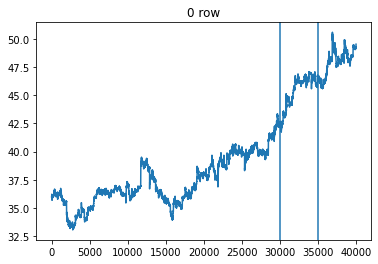

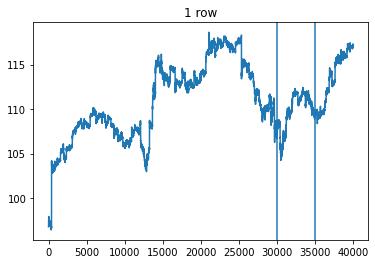

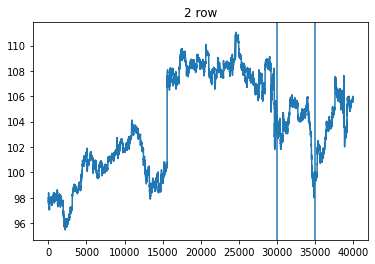

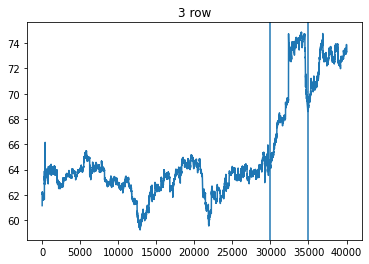

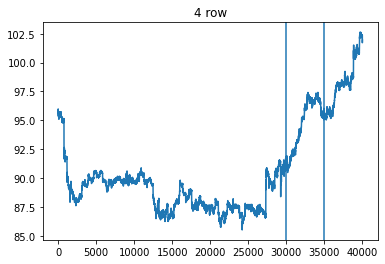

In [9]:
for row_ind in range(d_size):
    preprocessor.plot_row(row=row_ind)

As we can see, there is no point to predict for 0, 3 and 4 rows because the range of values in validation and test part significantly differes from the train part.

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

In [143]:
class LSTM_mymy(nn.Module):
    def __init__(self, sequence_len=14, hidden_dim=64, input_size=2):
        super(LSTM_mymy, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=input_size)

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs.float())
        out_last = self.linear(lstm_out[:, -1, :])
        return out_last

In [165]:
model = LSTM_mymy(hidden_dim=128)
loss_function = torch.nn.L1Loss()

In [177]:
optimizer = optim.SGD(model.parameters(), lr=0.05)

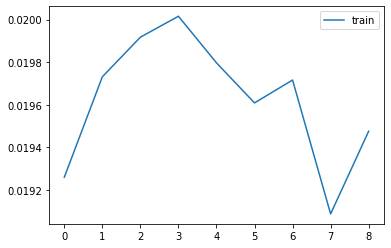

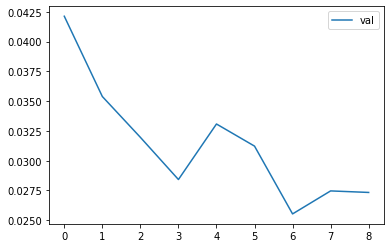

In [ ]:
train_losses = []
val_losses = []
for epoch in tqdm.tqdm_notebook(range(300)):  # again, normally you would NOT do 300 epochs, it is toy data
#     for sentence, tags in training_data:
    losses = []
    for X_batch, y_batch in preprocessor.get_train_dataloader():
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 3. Run our forward pass.
        model_output = model(X_batch[:, :, 1:3])

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(model_output, y_batch[:, :, 1:3].mean(dim=1).float())
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().item())
    train_losses.append(np.array(losses).mean())
    
    losses = [] 
    with torch.no_grad():
        for X_batch, y_batch in preprocessor.get_val_dataloader():
            model_output = model(X_batch[:, :, 1:3])
            loss = loss_function(model_output, y_batch[:, :, 1:3].mean(dim=1).float())
            losses.append(loss.detach().item())
    val_losses.append(np.array(losses).mean())
    clear_output(True)
    plt.plot(train_losses, label='train')
    plt.legend()
    plt.show()
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.show()

In [171]:
with torch.no_grad():
    for X_batch, y_batch in preprocessor.get_val_dataloader():
        model_output = model(X_batch[:, :, 1:3])
#         for i in range(model_output.shape[0]):
#             print(model_output[i])
#             print(y_batch[:, :, 1:3].mean(dim=1).float()[i])
#             print(loss_function(model_output[i], y_batch[:, :, 1:3].mean(dim=1).float()[i]))
#             print("___")
    print(loss_function(model_output, y_batch[:, :, 1:3].mean(dim=1).float()))
    raise 

tensor(0.4171)


RuntimeError: No active exception to reraise

In [90]:
for x, y_batch in preprocessor.get_val_dataloader():
    print(y_batch.mean(dim=1).shape)
    raise

torch.Size([128, 5])


RuntimeError: No active exception to reraise